# First data explorations 

## This is also necessary for ascertaining some model assumptions

In this notebook we analyse the consumption and other country data a bit more in detail to see what are its systematics
We answer questions like 

1. What is the ratio between GDP per capita and consumption exp. per capita?  
2. How does this ratio change with cons. exp pc?
3. Is there a relationship between GDP per capita and carbon intensity? 

and more..

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
# read the csv file data_nowcasted.extended.csv into a pandas dataframe from the data folder
data = pd.read_csv('./data/pip_all_data/data_nowcasted_extended.csv')


C:\Users\yoswald\AppData\Local\Temp\ipykernel_21532\4207310129.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


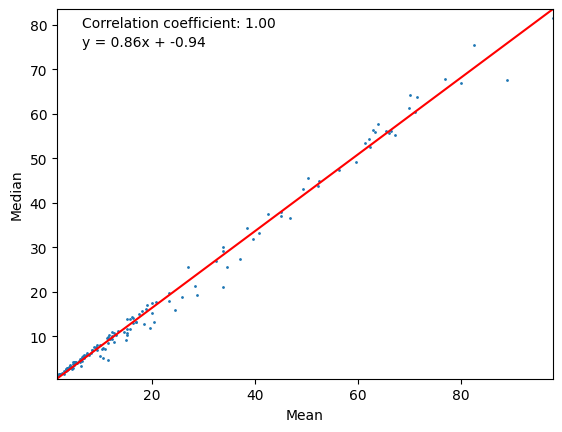

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Your existing code for scatterplot and linear fit line
plt.scatter(data['mean'], data['median'], s=1)
plt.plot(np.unique(data['mean']), np.poly1d(np.polyfit(data['mean'], data['median'], 1))(np.unique(data['mean'])), color='red')
plt.xlabel('Mean')
plt.ylabel('Median')
plt.margins(0)

# Calculating correlation coefficient and linear fit equation
correlation_coef = np.corrcoef(data['mean'], data['median'])[0][1]
linear_fit_eq = np.poly1d(np.polyfit(data['mean'], data['median'], 1))

# Formatting annotations with two significant digits
formatted_correlation = f"{correlation_coef:.2f}"
formatted_linear_fit_eq = f"y = {linear_fit_eq.coefficients[0]:.2f}x + {linear_fit_eq.coefficients[1]:.2f}"

# Annotating the plot
plt.annotate(f'Correlation coefficient: {formatted_correlation}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(formatted_linear_fit_eq, xy=(0.05, 0.9), xycoords='axes fraction')

plt.show()


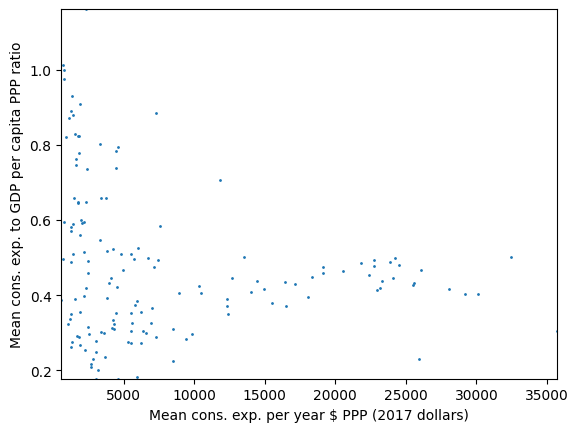

In [4]:
# calculate mean to gdp_pc_ppp ratio and plot as a scatter plot agasint the mean of the data dataframe
# calculate the mean to gdp_pc_ppp ratio
data['mean_to_gdp_pc_ppp_ratio'] = data['mean']*365/data['gdp_pc_ppp_2017']
# plot the mean_to_gdp_pc_ppp_ratio against the mean
plt.scatter(data['mean']*365, data['mean_to_gdp_pc_ppp_ratio'], s=1) # mean is multiplied by 365 to convert from mean per day to mean per year
plt.xlabel('Mean cons. exp. per year $ PPP (2017 dollars)')
plt.ylabel('Mean cons. exp. to GDP per capita PPP ratio')
plt.margins(0)
plt.show()

## Fit a model to this data which looks a potential energy function from physics e.g. Morse or lennard-jones potential
## But this is diffcult so we just fit a linear trend from 0 to 6000 and from 6000 to 3500

c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:980: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
C:\Users\yoswald\AppData\Local\Temp\ipykernel_21532\1450972619.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  exp_params = curve_fit(exponential, data[x_col], data[y_col])[0]
C:\Users\yoswald\AppData\Local\Temp\ipykernel_21532\1450972619.py:12: RuntimeWarning: overflow encountered in exp
  exp_val = a * np.exp(b * x)


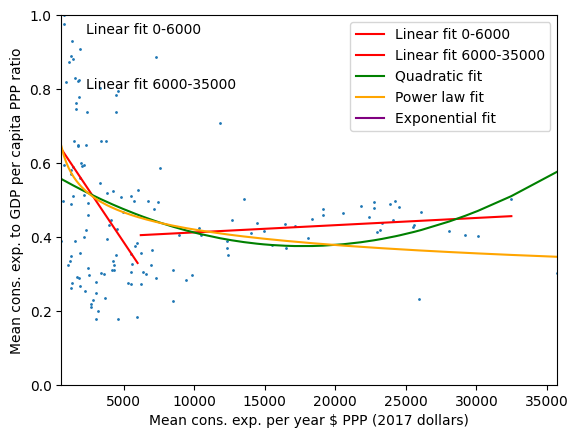

In [14]:
def linear_fit(data, x_col, y_col):
    return np.poly1d(np.polyfit(data[x_col], data[y_col], 1))

def quadratic_fit(data, x_col, y_col):
    return np.poly1d(np.polyfit(data[x_col], data[y_col], 2))

def power_law(x, a, b):
    return a * np.power(x, b)

def exponential(x, a, b):
    # Adding a check to avoid overflow
    exp_val = a * np.exp(b * x)
    return np.where(exp_val < 1e300, exp_val, 1e300)

def fit_and_plot(data, x_col, y_col):
    # Linear fits in specified ranges
    ranges = [(0, 6000), (6000, 35000)]
    linear_fits = []
    for start, end in ranges:
        mask = (data[x_col] >= start) & (data[x_col] <= end)
        fit = linear_fit(data[mask], x_col, y_col)
        linear_fits.append(fit)
        plt.plot(np.unique(data[mask][x_col]), fit(np.unique(data[mask][x_col])), color='red')

    # Quadratic and Power Law fits
    quad_fit = quadratic_fit(data, x_col, y_col)
    power_law_params = curve_fit(power_law, data[x_col], data[y_col])[0]
    plt.plot(np.unique(data[x_col]), quad_fit(np.unique(data[x_col])), color='green')
    plt.plot(np.unique(data[x_col]), power_law(np.unique(data[x_col]), *power_law_params), color='orange')

    # Exponential fit with error handling
    try:
        exp_params = curve_fit(exponential, data[x_col], data[y_col])[0]
        plt.plot(np.unique(data[x_col]), exponential(np.unique(data[x_col]), *exp_params), color='purple')
    except RuntimeError as e:
        print("Error in exponential fit:", e)

    # Annotations and plotting
    for i, (start, end) in enumerate(ranges):
        plt.annotate(f'Linear fit {start}-{end}', xy=(0.05, 0.95 - i*0.15), xycoords='axes fraction')
    
    plt.scatter(data[x_col], data[y_col], s=1)
    plt.xlabel('Mean cons. exp. per year $ PPP (2017 dollars)')
    plt.ylabel('Mean cons. exp. to GDP per capita PPP ratio')
    plt.legend(['Linear fit 0-6000', 'Linear fit 6000-35000', 'Quadratic fit', 'Power law fit', 'Exponential fit'])
    plt.margins(0)
    plt.ylim(0, 1)
    plt.show()

# Adding a temporary column
data['temp_mean_yearly'] = data['mean']*365

# Updated example usage
data['mean_to_gdp_pc_ppp_ratio'] = data['mean']*365/data['gdp_pc_ppp_2017']
fit_and_plot(data, 'temp_mean_yearly', 'mean_to_gdp_pc_ppp_ratio')

##### the outcome of the above plotting exercise is basically that it makes, when keeping things super simple, sense to let countries have their current ratios up to mean cons.exp per year of 10000 and then fix the ratio at 0.4 or slightly above (although this is a cross country analysis and it does not necessarily tell us anything about individual country trajectories)

# Now check whether there is a relationship between GDP and carbon intensity

There is likely no cross-country relationship but that does not mean there is no relationship for each country individually over time.
Does faster economic growth lead to faster or slower or unchanged carbon intensity reduction?

Text(0, 0.5, 'Carbon intensity (kg CO2 per 2017 dollars)')

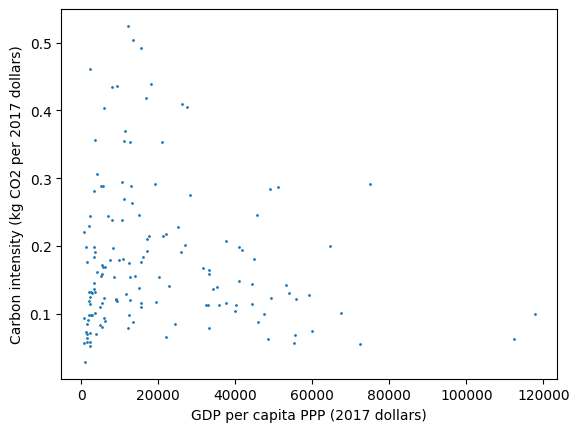

In [6]:
# plot on a scatterplot gdp_ppp_pc_2017 against carbon_intensity
plt.scatter(data['gdp_pc_ppp_2017'], data['carbon_intensity'], s=1)
plt.xlabel('GDP per capita PPP (2017 dollars)')
plt.ylabel('Carbon intensity (kg CO2 per 2017 dollars)')

## Check whether there is a relationship between economic growth and technology evolution i.e. carbon intensity reduction

ABW
AFE
AFG
AFW
AGO
ALB
AND
ARB
ARE
ARG
ARM
ASM
ATG
AUS
AUT
AZE
BDI
BEL
BEN
BFA
BGD
BGR
BHR
BHS
BIH
BLR
BLZ
BMU
BOL
BRA
BRB
BRN
BTN
BWA
CAF
CAN
CEB
CHE
CHI
CHL
CHN
CIV
CMR
COD
COG
COL
COM
CPV
CRI
CSS
CUB
CUW
CYM
CYP
CZE
DEU
DJI
DMA
DNK
DOM
DZA
EAP
EAR
EAS
ECA
ECS
ECU
EGY
EMU
ERI
ESP
EST
ETH
EUU
FCS
FIN
FJI
FRA
FRO
FSM
GAB
GBR
GEO
GHA
GIB
GIN
GMB
GNB
GNQ
GRC
GRD
GRL
GTM
GUM
GUY
HIC
HKG
HND
HPC
HRV
HTI
HUN
IBD
IBT
IDA
IDB
IDN
IDX
IMN
IND
INX
IRL
IRN
IRQ
ISL
ISR
ITA
JAM
JOR
JPN
KAZ
KEN
KGZ
KHM
KIR
KNA
KOR
KWT
LAC
LAO
LBN
LBR
LBY
LCA
LCN
LDC
LIC
LIE
LKA
LMC
LMY
LSO
LTE
LTU
LUX
LVA
MAC
MAF
MAR
MCO
MDA
MDG
MDV
MEA
MEX
MHL
MIC
MKD
MLI
MLT
MMR
MNA
MNE
MNG
MNP
MOZ
MRT
MUS
MWI
MYS
NAC
NAM
NCL
NER
NGA
NIC
NLD
NOR
NPL
NRU
NZL
OED
OMN
OSS
PAK
PAN
PER
PHL
PLW
PNG
POL
PRE
PRI
PRK
PRT
PRY
PSE
PSS
PST
PYF
QAT
ROU
RUS
RWA
SAS
SAU
SDN
SEN
SGP
SLB
SLE
SLV
SMR
SOM
SRB
SSA
SSD
SSF
SST
STP
SUR
SVK
SVN
SWE
SWZ
SXM
SYC
SYR
TCA
TCD
TEA
TEC
TGO
THA
TJK
TKM
TLA
TLS
TMN
TON
TSA
TSS
TTO
TUN
TUR
TUV
TZA
UGA
UKR
UMC


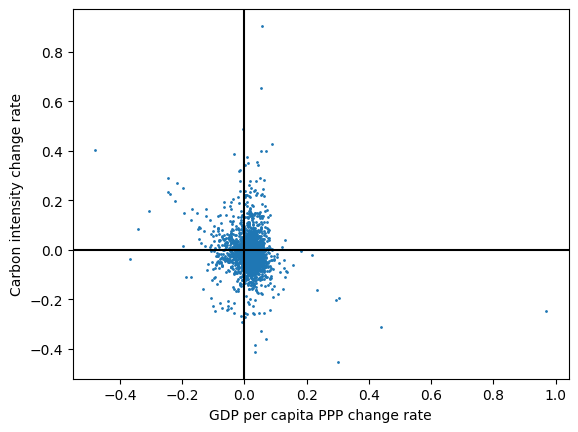

In [7]:
# import gdp_pc_ppp and carbon_intensity into numpy arrays then loop over all countries and compute for gdp per capita and carbon intensity the change rate from year to year from 2010 to 2020
# import gdp_pc_ppp and carbon_intensity from the csv data file which is not loaded yet into dataframes
# Importing the data
gdp_pc_ppp = pd.read_csv('./data/pip_all_data/gdp_pc_ppp.csv')
carbon_intensity = pd.read_csv('./data/pip_all_data/carbon_intensity.csv')

# Assuming 'data' is another DataFrame that contains 'country_code'
# countries = data['country_code'].unique()
countries = gdp_pc_ppp['Country Code'].unique()  # Modify as per your actual DataFrame
years = list(np.arange(2010, 2021))

# Initialize an empty DataFrame for storing all change rates
all_change_rates_df = pd.DataFrame()

for country in countries:
    print(country)
    # Get the index for the current country in each DataFrame
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_ci = carbon_intensity[carbon_intensity['Country Code'] == country].index[0]

    # Extracting the values for each year
    gdp_pc_ppp_values = [gdp_pc_ppp.at[country_row_gdp, str(year)] for year in years]
    carbon_intensity_values = [carbon_intensity.at[country_row_ci, str(year)] for year in years]

    # Computing the change rate
    gdp_pc_ppp_change_rate = [(gdp_pc_ppp_values[i+1] - gdp_pc_ppp_values[i]) / gdp_pc_ppp_values[i] for i in range(len(years) - 1)]
    carbon_intensity_change_rate = [(carbon_intensity_values[i+1] - carbon_intensity_values[i]) / carbon_intensity_values[i] for i in range(len(years) - 1)]

    # Creating a dictionary for the change rates
    change_rate_dict = {
        'country_code': country,
        'gdp_pc_ppp_change_rate': gdp_pc_ppp_change_rate,
        'carbon_intensity_change_rate': carbon_intensity_change_rate
    }

    # Convert the dictionary to a DataFrame
    change_rate_df = pd.DataFrame(change_rate_dict)

    # Append this DataFrame to the cumulative DataFrame
    all_change_rates_df = pd.concat([all_change_rates_df, change_rate_df], ignore_index=True)

# The final DataFrame contains all the change rates for each country
print(all_change_rates_df)


# save this dataframe as a csv file
all_change_rates_df.to_csv('./data/pip_all_data/all_change_rates.csv', index=False)

# plot on a scatterplot gdp change rate against carbon intensity change rate
plt.scatter(all_change_rates_df['gdp_pc_ppp_change_rate'], all_change_rates_df['carbon_intensity_change_rate'], s=1)
plt.xlabel('GDP per capita PPP change rate')
plt.ylabel('Carbon intensity change rate')
# add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')
# add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-')

ABW
AFE
AFG
AFW
AGO
ALB
AND
ARB
ARE
ARG
ARM
ASM
ATG
AUS
AUT
AZE
BDI
BEL
BEN
BFA
BGD
BGR
BHR
BHS
BIH
BLR
BLZ
BMU
BOL
BRA
BRB
BRN
BTN
BWA
CAF
CAN
CEB
CHE
CHI
CHL
CHN
CIV
CMR
COD
COG
COL
COM
CPV
CRI
CSS
CUB
CUW
CYM
CYP
CZE
DEU
DJI
DMA
DNK
DOM
DZA
EAP
EAR
EAS
ECA
ECS
ECU
EGY
EMU
ERI
ESP
EST
ETH
EUU
FCS
FIN
FJI
FRA
FRO
FSM
GAB
GBR
GEO
GHA
GIB
GIN
GMB
GNB
GNQ
GRC
GRD
GRL
GTM
GUM
GUY
HIC
HKG
HND
HPC
HRV
HTI
HUN
IBD
IBT
IDA
IDB
IDN
IDX
IMN
IND
INX
IRL
IRN
IRQ
ISL
ISR
ITA
JAM
JOR
JPN
KAZ
KEN
KGZ
KHM
KIR
KNA
KOR
KWT
LAC
LAO
LBN
LBR
LBY
LCA
LCN
LDC
LIC
LIE
LKA
LMC
LMY
LSO
LTE
LTU
LUX
LVA
MAC
MAF
MAR
MCO
MDA
MDG
MDV
MEA
MEX
MHL
MIC
MKD
MLI
MLT
MMR
MNA
MNE
MNG
MNP
MOZ
MRT
MUS
MWI
MYS
NAC
NAM
NCL
NER
NGA
NIC
NLD
NOR
NPL
NRU
NZL
OED
OMN
OSS
PAK
PAN
PER
PHL
PLW
PNG
POL
PRE
PRI
PRK
PRT
PRY
PSE
PSS
PST
PYF
QAT
ROU
RUS
RWA
SAS
SAU
SDN
SEN
SGP
SLB
SLE
SLV
SMR
SOM
SRB
SSA
SSD
SSF
SST
STP
SUR
SVK
SVN
SWE
SWZ
SXM
SYC
SYR
TCA
TCD
TEA
TEC
TGO
THA
TJK
TKM
TLA
TLS
TMN
TON
TSA
TSS
TTO
TUN
TUR
TUV
TZA
UGA
UKR
UMC


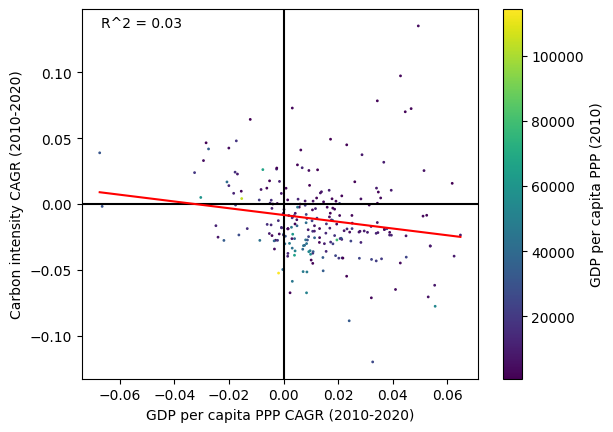

In [8]:
# Assuming 'data' is another DataFrame that contains 'country_code'
countries = gdp_pc_ppp['Country Code'].unique()  # Modify as per your actual DataFrame
years = list(np.arange(2010, 2021))

# Initialize an empty list for storing CAGR data
cagr_data = []

for country in countries:
    print(country)
    # Get the index for the current country in each DataFrame
    country_row_gdp = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country].index[0]
    country_row_ci = carbon_intensity[carbon_intensity['Country Code'] == country].index[0]

    # Extracting the values for the first and last year
    gdp_start = gdp_pc_ppp.at[country_row_gdp, str(years[0])]
    gdp_end = gdp_pc_ppp.at[country_row_gdp, str(years[-1])]
    ci_start = carbon_intensity.at[country_row_ci, str(years[0])]
    ci_end = carbon_intensity.at[country_row_ci, str(years[-1])]

    # Computing CAGR
    n_years = years[-1] - years[0]
    gdp_cagr = (gdp_end / gdp_start) ** (1/n_years) - 1
    ci_cagr = (ci_end / ci_start) ** (1/n_years) - 1

    # Appending the result to the list
    cagr_data.append({
        'country_code': country, 
        'gdp_pc_ppp_cagr': gdp_cagr, 
        'carbon_intensity_cagr': ci_cagr
    })

# Convert the list of dictionaries to a DataFrame
cagr_df = pd.DataFrame(cagr_data)

# Add GDP per capita PPP for 2010 to cagr_data
for item in cagr_data:
    country_code = item['country_code']
    country_row = gdp_pc_ppp[gdp_pc_ppp['Country Code'] == country_code].index[0]
    item['gdp_pc_ppp_2010'] = gdp_pc_ppp.at[country_row, '2010']  # Assuming '2010' is the column name

# Update cagr_df with the new data
cagr_df = pd.DataFrame(cagr_data)


# Save the CAGR DataFrame as a CSV file
cagr_df.to_csv('./data/pip_all_data/cagr.csv', index=False)

# Remove any rows with NaN or infinite values
cleaned_cagr_df = cagr_df.dropna().replace([np.inf, -np.inf], np.nan).dropna()

## Create a colormap for the scatter plot
norm = plt.Normalize(cleaned_cagr_df['gdp_pc_ppp_2010'].min(), cleaned_cagr_df['gdp_pc_ppp_2010'].max())
colors = cm.viridis(norm(cleaned_cagr_df['gdp_pc_ppp_2010']))

# Check if there are enough unique values to perform linear regression
if len(np.unique(cleaned_cagr_df['gdp_pc_ppp_cagr'])) > 1 and len(np.unique(cleaned_cagr_df['carbon_intensity_cagr'])) > 1:
    # Fit the linear model
    coefficients = np.polyfit(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'], 1)
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(cleaned_cagr_df['gdp_pc_ppp_cagr'].min(), cleaned_cagr_df['gdp_pc_ppp_cagr'].max(), 100)
    y_axis = polynomial(x_axis)

    # Plotting the CAGR values
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.scatter(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'], color=colors, s=1)
    ax.set_xlabel('GDP per capita PPP CAGR (2010-2020)')
    ax.set_ylabel('Carbon intensity CAGR (2010-2020)')
    ax.axhline(y=0, color='black', linestyle='-')
    ax.axvline(x=0, color='black', linestyle='-')
    # Add a linear fit line
    ax.plot(x_axis, y_axis, color='red')
    # Color countries based on their absolute GDP per capita PPP in 2010
    # Adding a colorbar for reference
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, label='GDP per capita PPP (2010)')
    # plot the R^2 value
    r_squared = np.corrcoef(cleaned_cagr_df['gdp_pc_ppp_cagr'], cleaned_cagr_df['carbon_intensity_cagr'])[0][1] ** 2
    ax.annotate(f'R^2 = {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

    plt.show()
else:
    print("Insufficient variability in data for linear regression.")

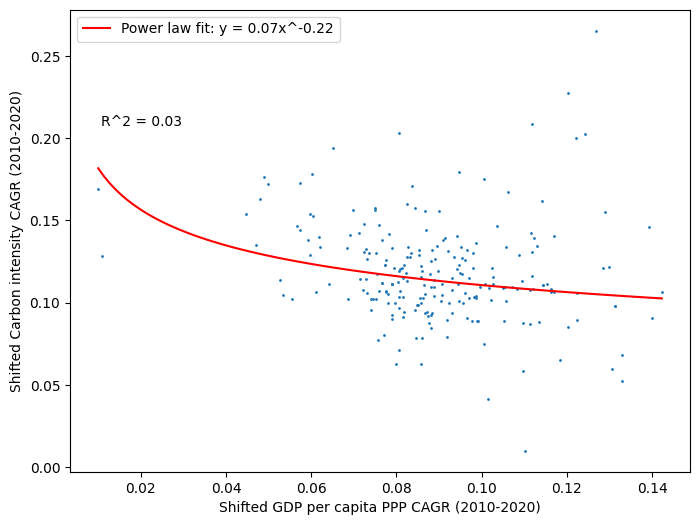

Elasticity of carbon intensity reduction with respect to GDP CAGR: -0.22


In [9]:
# Now fit a power law also

# ... [Your existing code ends here] ...

# Shift the data to make all values positive
min_gdp_cagr = np.abs(cleaned_cagr_df['gdp_pc_ppp_cagr'].min())
min_ci_cagr = np.abs(cleaned_cagr_df['carbon_intensity_cagr'].min())
cleaned_cagr_df['shifted_gdp_cagr'] = cleaned_cagr_df['gdp_pc_ppp_cagr'] + min_gdp_cagr + 0.01  # Avoid zero values
cleaned_cagr_df['shifted_ci_cagr'] = cleaned_cagr_df['carbon_intensity_cagr'] + min_ci_cagr + 0.01

# Log-transform the data
cleaned_cagr_df['log_gdp_cagr'] = np.log(cleaned_cagr_df['shifted_gdp_cagr'])
cleaned_cagr_df['log_ci_cagr'] = np.log(cleaned_cagr_df['shifted_ci_cagr'])

# Fit a linear model to the log-transformed data
coefficients, _ = np.polyfit(cleaned_cagr_df['log_gdp_cagr'], cleaned_cagr_df['log_ci_cagr'], 1, cov=True)

# The power law relationship: y = ax^b becomes linear when log-transformed: log(y) = log(a) + b*log(x)
a = np.exp(coefficients[1])  # Intercept is log(a), so a = exp(intercept)
b = coefficients[0]  # Slope is the exponent in the power law

# Create the power law function for plotting
def power_law(x, a, b):
    return a * np.power(x, b)

# Generate x values for plotting the power law
x_values = np.linspace(cleaned_cagr_df['shifted_gdp_cagr'].min(), cleaned_cagr_df['shifted_gdp_cagr'].max(), 100)

# Plotting the power law model
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_cagr_df['shifted_gdp_cagr'], cleaned_cagr_df['shifted_ci_cagr'], s=1)
plt.plot(x_values, power_law(x_values, a, b), color='red', label=f'Power law fit: y = {a:.2f}x^{b:.2f}')
plt.xlabel('Shifted GDP per capita PPP CAGR (2010-2020)')
plt.ylabel('Shifted Carbon intensity CAGR (2010-2020)')
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
# plot the R^2 value
plt.annotate(f'R^2 = {np.corrcoef(cleaned_cagr_df["shifted_gdp_cagr"], cleaned_cagr_df["shifted_ci_cagr"])[0][1]**2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
plt.show()

# Print the elasticity (exponent b in the power law)
print(f"Elasticity of carbon intensity reduction with respect to GDP CAGR: {b:.2f}")